In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *
import glob
#import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
feos_pcsaft.__file__

'/usr/ITT/bursik/promotion/entropy_scaling_AS/entropyScaling/venv_entropyscaling/lib/python3.8/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

In [2]:
components = ['propane']#, 'pentane']
composition = np.array([0.3, 0.7]) *MOL
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [5]:
params = PcSaftParameters.from_json(components, 'parameters/propane_with_entropy_scaling.json')
func = PcSaftFunctional(params)
eos = PcSaft(params)
func_hs = (params)

In [6]:
if len(components) == 1:
    t_crit = State.critical_point_pure(func)[0].temperature
    vle = PhaseEquilibrium.pure_t(func, temperature)
else:
    t_crit = State.critical_point(func, composition).temperature
    vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition/MOL)
vle

||temperature|density|
|-|-|-|
|phase 1|298.15000 K|460.35608  mol/m³|
|phase 2|298.15000 K|11.16768 kmol/m³|


In [9]:
eos

In [18]:
state  =State(func, temperature=temperature, pressure=pressure/BAR*PASCAL)

In [19]:
state.viscosity

AttributeError: 'builtins.State' object has no attribute 'viscosity'

In [15]:
solver = DFTSolver(output=False).picard_iteration(tol=1.0e-8, beta=0.01, max_iter=30, log=False).anderson_mixing(tol=1.0e-9,mmax=10)#
interface = PlanarInterface.from_tanh(vle, 1024, 80 * ANGSTROM, t_crit)
density_init = interface.density


In [16]:
interface.solve(solver, debug=False)   


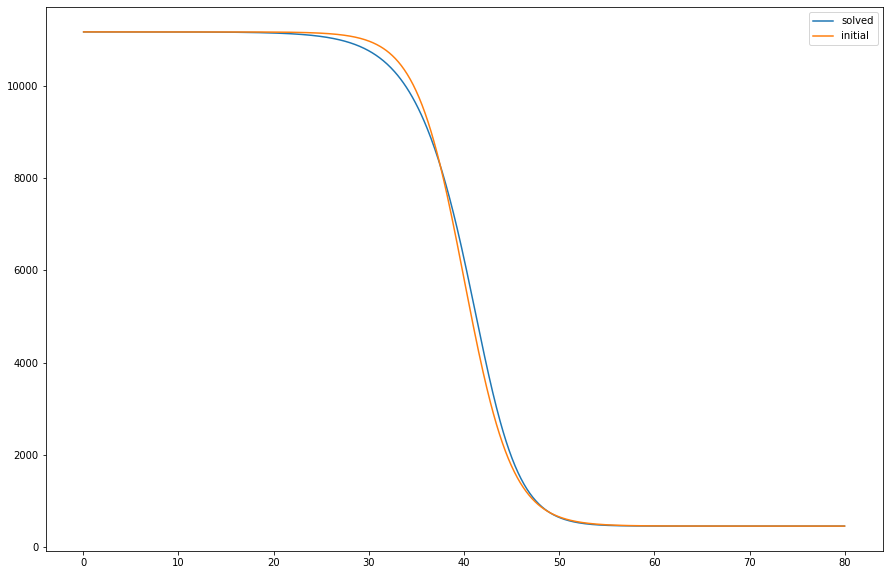

In [17]:
plt.figure(figsize=[15,10])
plt.plot(interface.z/ANGSTROM, (interface.density/MOL*METER**3)[0], label='solved')
plt.plot(interface.z/ANGSTROM, (density_init/MOL*METER**3)[0], label='initial')
plt.legend()

In [18]:
interface.weighted_densities

[array([[ 5.37489785e-01,  5.37489781e-01,  5.37489774e-01, ...,
          2.21569673e-02,  2.21569673e-02,  2.21569673e-02],
        [ 3.19346307e-01,  3.19346304e-01,  3.19346300e-01, ...,
          1.31644250e-02,  1.31644250e-02,  1.31644250e-02],
        [-1.38590024e-08, -4.15871354e-08, -6.93456229e-08, ...,
         -8.83390426e-11, -5.29546999e-11, -1.76434514e-11]]),
 array([[6.72524255e-03, 6.72524250e-03, 6.72524242e-03, ...,
         2.77234833e-04, 2.77234833e-04, 2.77234833e-04],
        [6.72522617e-03, 6.72522611e-03, 6.72522600e-03, ...,
         2.77234855e-04, 2.77234855e-04, 2.77234855e-04],
        [3.19345959e-01, 3.19345956e-01, 3.19345952e-01, ...,
         1.31644255e-02, 1.31644255e-02, 1.31644255e-02]]),
 array([[0.00672522, 0.00672522, 0.00672522, ..., 0.00027723, 0.00027723,
         0.00027723]])]

In [19]:
interface.viscosity_profile

[0.0000758500616485806, 0.00007585006060670333, 0.00007585005852124308, 0.00007585005538880033, 0.00007585005120430698, ..., 0.000008366591470125494, 0.000008366591510523316, 0.000008366591540755912, 0.000008366591560879138, 0.000008366591570930018] Pas

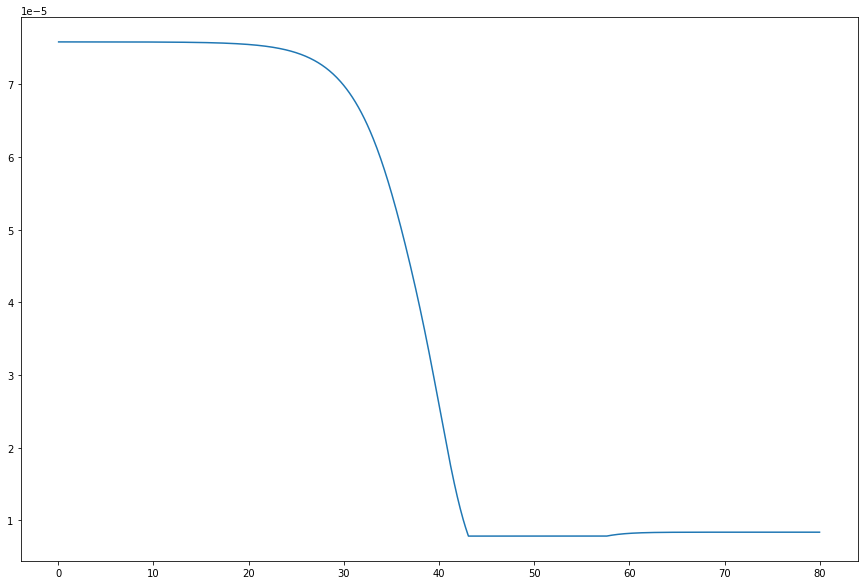

In [30]:
plt.figure(figsize=[15,10])

plt.plot(interface.z/ANGSTROM, interface.viscosity_profile/PASCAL/SECOND)
